Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
...training accuracy 0.121
prob 0.100000, test accuracy 0.2748
...training accuracy 0.232
prob 0.250000, test accuracy 0.566
...training accuracy 0.702
prob 0.500000, test accuracy 0.805
...training accuracy 0.878
prob 0.750000, test accuracy 0.8584
...training accuracy 1
prob 1.000000, test accuracy 0.8355
Done!


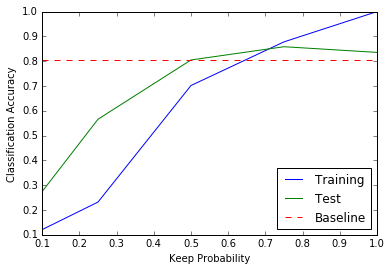

In [1]:
%matplotlib inline

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.examples.tutorials.mnist import input_data

#
# ==================================================================
#

def weight_variable(shape):
    initial = tf.truncated_normal( shape, stddev=0.1 )
    return tf.Variable( initial )

def bias_variable(shape):
    initial = tf.constant( 0.1, shape=shape )
    return tf.Variable(initial)

#
# ==================================================================
#


learning_rate = 0.001

# Place holders
y_ = tf.placeholder( tf.float32, shape=[None, 10], name="y_" )
x = tf.placeholder( tf.float32, [None, 784], name="x" )
keep_prob = tf.placeholder(tf.float32) #dropout (keep probability)
scale_val = tf.placeholder(tf.float32) 
s = False
# Defining computation graph for training

def trainWithDropOut(X, scale):
    W1 = weight_variable([784, 500])
    b1 = bias_variable([500])
    h1 = tf.nn.relu(tf.matmul( X, W1 ) + b1)
    
    # Adding dropout 
    u1 = tf.to_float(tf.less(tf.random_uniform(tf.shape(h1), minval=0, maxval=1), keep_prob))
    
    # Dropping
    h1 *= u1 
    
    if scale:
        h1 = tf.mul(h1, scale_val)

    W2 = weight_variable([500, 500])
    b2 = bias_variable([500])
    h2 = tf.nn.relu(tf.matmul( h1, W2 ) + b2)

    # Adding dropout
    u2 = tf.to_float(tf.less(tf.random_uniform(tf.shape(h2), minval=0, maxval=1), keep_prob))
    
    # Dropping
    h2 *= u2
    
    if scale:
        h1 = tf.mul(h2, scale_val)
        
    W3 = weight_variable([500, 1000])
    b3 = bias_variable([1000])
    h3 = tf.nn.relu(tf.matmul( h2, W3 ) + b3)

    # Adding dropout
    u3 = tf.to_float(tf.less(tf.random_uniform(tf.shape(h3), minval=0, maxval=1), keep_prob))
    if scale:
        u3 = tf.mul(u3, scale_val)
    # Dropping
    h3 *= u3 
    
    if scale:
        h3 = tf.mul(h3, scale_val)
    
    out = h3
    return out


# Construct Training Model
out = trainWithDropOut(x, s)
W4 = weight_variable([1000, 10])
b4 = bias_variable([10])
y_hat = tf.nn.softmax(tf.matmul(out, W4) + b4)

cross_entropy = tf.reduce_mean(-tf.reduce_sum(y_ * tf.log(y_hat), reduction_indices=[1]))
xent_summary = tf.scalar_summary( 'xent', cross_entropy )

correct_prediction = tf.equal(tf.argmax(y_hat,1), tf.argmax(y_,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
acc_summary = tf.scalar_summary( 'accuracy', accuracy )

train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)

#
# ==================================================================
#

sess = tf.Session()
sess.run( tf.initialize_all_variables() )

#
# ==================================================================
#

# NOTE: we're using a single, fixed batch of the first 1000 images
mnist = input_data.read_data_sets( "MNIST_data/", one_hot=True )

images = mnist.train.images[ 0:1000, : ]
labels = mnist.train.labels[ 0:1000, : ]
#keep_probs = [ 0.1, 1.0]
#keep_probs = [ 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.40, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.80, 0.85, 0.9, 0.95, 1.0 ]
#keep_probs = [ 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.80, 0.85, 0.9, 0.95, 1.0 ]
keep_probs = [ 0.1, 0.25, 0.5, 0.75, 1.0 ]
#keep_probs = [0.5, 0.75, 1.0]
trainingAcc = []
testAcc = []
for k_prob in keep_probs:
    sess.run( tf.initialize_all_variables() )
    s = False
    for i in range( 150 ):
        _, acc = sess.run( [ train_step, accuracy ], feed_dict={ x: images, y_: labels, keep_prob: k_prob, scale_val: 1} )
        
    print( "...training accuracy %g" % acc )
    trainingAcc.append(acc)
    s = True
    final_acc = sess.run( accuracy, feed_dict={ x: mnist.test.images, y_: mnist.test.labels, keep_prob: 1, scale_val: k_prob} )
    print( "prob %f, test accuracy %g" % (k_prob, final_acc) )
    testAcc.append(final_acc) 
    
print ("Done!")

baseline = 0.8068
plt.plot(keep_probs, trainingAcc, color="blue")
plt.plot(keep_probs, testAcc, color="green")
plt.axhline(baseline, color='r', linestyle='--')

plt.legend(['Training', 'Test', 'Baseline'], loc='lower right')
plt.xlabel("Keep Probability")
plt.ylabel("Classification Accuracy")
plt.show()
